# The Simplest NN
This code builds a 2-layer NN and applies it to recogition of handwritten digits.
Tested on Python 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)] on win32,
Windows 10 Pro 64 Bit, Intel Core i5-2500 @ 3.30 GHz

In [1]:
import tensorflow as tf
import numpy as np
import os

Here we load 'mnist' dataset of handwritten images (https://keras.io/datasets/) with help of an already provided function *load_dataset*. Be sure that the file *preprocessed_mnist.py* is in your working directory.

Now we also want to know the shapes of the original train/test-data and visualize some symbols from the train data. We will want to classify each handwritten symbol as a digit: 0,1,...,9.

(50000, 28, 28) (50000,)
(10000, 28, 28) (10000,)


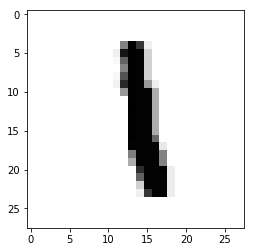

In [3]:
# os.chdir("D:\\Downloads\\")
from preprocessed_mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[5], cmap="Greys")
plt.imshow(X_train[6], cmap="Greys")

We want the image data to be in a flat format, so let's reload the reshaped version of the dataset and print new shapes.

In [4]:
X_train_flat, y_train, X_val_flat, y_val, X_test_flat, y_test = load_dataset(flatten=True)
print("X and y train shape:", X_train_flat.shape, y_train.shape)
print("X and y test shape:", X_test_flat.shape, y_test.shape)

X and y train shape: (50000, 784) (50000,)
X and y test shape: (10000, 784) (10000,)


We will also want to convert categorical labels of 10 classes to binary format.

In [5]:
s = tf.Session()

# Categorical labels to binaries
y_train_oh = s.run(tf.one_hot(y_train, 10))
y_test_oh  = s.run(tf.one_hot(y_test, 10))
y_val_oh   = s.run(tf.one_hot(y_val, 10))

# Logistic regression
Here we will implement our simple NN with 1 hidden layer having 50 neurons.

First let's create variables for weights and biases and placeholders for input data:

In [6]:
# Model parameters - weights and bias
nhid   = 50
nclass = len(np.unique(y_train))
weights_hid = tf.Variable(tf.random_normal([X_train_flat.shape[1], nhid], stddev=0.35),
                      name="weights_h") 

b_hid = tf.Variable(tf.zeros([nhid]), dtype='float32', name="biases_h")

weights_out = tf.Variable(tf.random_normal([nhid, nclass], stddev=0.35),
                      name="weights") 

b_out = tf.Variable(tf.zeros([nclass]), dtype='float32', name="biases")

# Placeholders for the input data
input_X = tf.placeholder('float32', shape=(None,X_train_flat.shape[1]))
input_y = tf.placeholder('float32', shape=(None, nclass))
input_X, input_y, weights_hid, weights_out, b_hid, b_out

(<tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'Placeholder_1:0' shape=(?, 10) dtype=float32>,
 <tf.Variable 'weights_h:0' shape=(784, 50) dtype=float32_ref>,
 <tf.Variable 'weights:0' shape=(50, 10) dtype=float32_ref>,
 <tf.Variable 'biases_h:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'biases:0' shape=(10,) dtype=float32_ref>)

Now implement the model itself. The outpit layer uses softmax non-linearity, hidden layer - *relu* activation function.

**Loss** will be a softmax cross entropy between log probabilities and labels.  
**Optimization method** - gradient decent.  
**Accuracy** is just a proportion of correct predictions.

In [7]:
# model
#predicted_y =  tf.nn.softmax(tf.matmul(input_X, weights)+b)
predicted_y_hid =  tf.nn.relu(tf.matmul(input_X, weights_hid)+b_hid)
predicted_y     =  tf.matmul(predicted_y_hid, weights_out)+b_out

# Loss. Should be a scalar number - average loss over all the objects
#loss = tf.reduce_mean(-tf.reduce_sum(tf.log(predicted_y+1e-07)*input_y, reduction_indices=[1]))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=predicted_y))

# See above for an example. tf.train.*Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(
    loss, var_list=(weights_hid, b_hid, weights_out, b_out))

# compute accuracy
correct_prediction = tf.equal(tf.argmax(predicted_y,1), tf.argmax(input_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We will make 400 learning iterations and also show loss, auc on train and test data for each iteration.

In [8]:
from sklearn.metrics import roc_auc_score

trainloss = list()
testloss  = list()
acctrain  = list()
acctest   = list()
s.run(tf.global_variables_initializer())


# run optimizing iterations
for i in range(400):
    #batchX, batchY = s.run(tf.train.batch([X_train_flat, y_train_oh],100,enqueue_many=True, capacity=1))
    s.run(optimizer, {input_X: X_train_flat, input_y: y_train_oh})
    #s.run(optimizer, {input_X: batchX, input_y: batchY})
    loss_i = s.run(loss, {input_X: X_train_flat, input_y: y_train_oh})
    trainloss.append(loss_i)
    loss_i = s.run(loss, {input_X: X_test_flat, input_y: y_test_oh})
    testloss.append(loss_i)
    acctrain.append(s.run(accuracy, feed_dict={input_X:X_train_flat, input_y: y_train_oh}))
    acctest.append(s.run(accuracy, feed_dict={input_X:X_test_flat, input_y: y_test_oh}))
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train auc:", roc_auc_score(y_train_oh, s.run(predicted_y, {input_X:X_train_flat})))
    print("test auc:", roc_auc_score(y_test_oh, s.run(predicted_y, {input_X:X_test_flat})))

loss at iter 0:6.8765
train auc: 0.687510221914
test auc: 0.687148972178
loss at iter 1:4.1253
train auc: 0.737293261747
test auc: 0.74093541607
loss at iter 2:2.3339
train auc: 0.780183826451
test auc: 0.78419227763
loss at iter 3:1.9347
train auc: 0.794150118034
test auc: 0.797733909147
loss at iter 4:1.7506
train auc: 0.808858981724
test auc: 0.812266050027
loss at iter 5:1.6170
train auc: 0.82165356534
test auc: 0.8248844439
loss at iter 6:1.5041
train auc: 0.833185658418
test auc: 0.836169214545
loss at iter 7:1.4038
train auc: 0.843643586786
test auc: 0.846442356625
loss at iter 8:1.3141
train auc: 0.853183937459
test auc: 0.855877009768
loss at iter 9:1.2351
train auc: 0.861926979035
test auc: 0.864690397658
loss at iter 10:1.1669
train auc: 0.8698987913
test auc: 0.872727050124
loss at iter 11:1.1077
train auc: 0.877120249253
test auc: 0.879969099024
loss at iter 12:1.0555
train auc: 0.883507153124
test auc: 0.886405002165
loss at iter 13:1.0092
train auc: 0.889069499892
test a

train auc: 0.953346915579
test auc: 0.955300570577
loss at iter 112:0.3971
train auc: 0.953469286446
test auc: 0.955417351302
loss at iter 113:0.3961
train auc: 0.953573979252
test auc: 0.955507890614
loss at iter 114:0.3948
train auc: 0.953695746138
test auc: 0.955622041934
loss at iter 115:0.3939
train auc: 0.953793632991
test auc: 0.955706903418
loss at iter 116:0.3925
train auc: 0.95391722033
test auc: 0.955824068852
loss at iter 117:0.3917
train auc: 0.954008576576
test auc: 0.955900736111
loss at iter 118:0.3904
train auc: 0.954134720101
test auc: 0.956024237156
loss at iter 119:0.3897
train auc: 0.954217549217
test auc: 0.956088912053
loss at iter 120:0.3883
train auc: 0.954350538409
test auc: 0.956220895013
loss at iter 121:0.3878
train auc: 0.954422310014
test auc: 0.956271435642
loss at iter 122:0.3863
train auc: 0.954563826919
test auc: 0.956417313922
loss at iter 123:0.3862
train auc: 0.954621764544
test auc: 0.956451672387
loss at iter 124:0.3846
train auc: 0.954777521191


loss at iter 221:0.3184
train auc: 0.962123448711
test auc: 0.963377267132
loss at iter 222:0.3180
train auc: 0.962176201286
test auc: 0.963426060582
loss at iter 223:0.3175
train auc: 0.962228923297
test auc: 0.963473629634
loss at iter 224:0.3171
train auc: 0.962281164571
test auc: 0.963520024982
loss at iter 225:0.3166
train auc: 0.962332955571
test auc: 0.963567777389
loss at iter 226:0.3161
train auc: 0.962385329307
test auc: 0.963614723203
loss at iter 227:0.3157
train auc: 0.962437595352
test auc: 0.963661598405
loss at iter 228:0.3152
train auc: 0.96248980897
test auc: 0.963709524044
loss at iter 229:0.3148
train auc: 0.962541489068
test auc: 0.963756495004
loss at iter 230:0.3143
train auc: 0.962593115096
test auc: 0.96380498635
loss at iter 231:0.3139
train auc: 0.962644577688
test auc: 0.963852541108
loss at iter 232:0.3134
train auc: 0.962696080006
test auc: 0.963898905308
loss at iter 233:0.3130
train auc: 0.962747130446
test auc: 0.963944999497
loss at iter 234:0.3125
tra

loss at iter 331:0.2783
train auc: 0.966861123599
test auc: 0.967747462546
loss at iter 332:0.2780
train auc: 0.96689637385
test auc: 0.967780030079
loss at iter 333:0.2777
train auc: 0.966931438156
test auc: 0.967813159394
loss at iter 334:0.2774
train auc: 0.966966558398
test auc: 0.967845493038
loss at iter 335:0.2771
train auc: 0.967002102891
test auc: 0.967879248054
loss at iter 336:0.2769
train auc: 0.967037045623
test auc: 0.967911504443
loss at iter 337:0.2766
train auc: 0.967072154427
test auc: 0.967945332921
loss at iter 338:0.2763
train auc: 0.967107094579
test auc: 0.967978800845
loss at iter 339:0.2760
train auc: 0.967141821343
test auc: 0.968009502259
loss at iter 340:0.2757
train auc: 0.967176563445
test auc: 0.968040688839
loss at iter 341:0.2755
train auc: 0.967211051275
test auc: 0.968073009083
loss at iter 342:0.2752
train auc: 0.967245267717
test auc: 0.968106899266
loss at iter 343:0.2749
train auc: 0.967279537052
test auc: 0.968137721835
loss at iter 344:0.2746
tr

Let's see the plots of loss and accuracy on train and test data for each iteration.

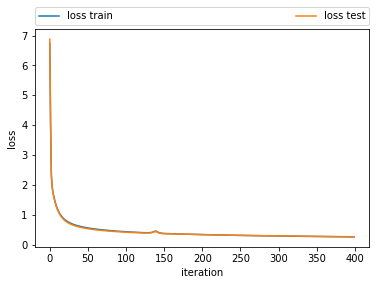

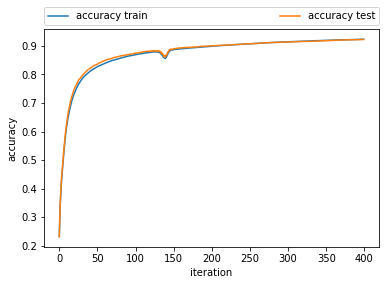

In [9]:
plt.plot(trainloss, label = "loss train")
plt.plot(testloss, label="loss test")
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

plt.plot(acctrain, label = "accuracy train")
plt.plot(acctest, label  = "accuracy test")
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()


Here we will print the accuracy (proportion of correct predictions) reached after 400 learning steps.

In [10]:
correct_prediction = tf.equal(tf.argmax(predicted_y,1), tf.argmax(input_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy on train data:", s.run(accuracy, feed_dict={input_X:X_train_flat, input_y: y_train_oh}))
print("Accuracy on val data:"  , s.run(accuracy, feed_dict={input_X:X_val_flat, input_y: y_val_oh}))
print("Accuracy on test data:" , s.run(accuracy, feed_dict={input_X:X_test_flat, input_y: y_test_oh}))

Accuracy on train data: 0.9229
Accuracy on val data: 0.9272
Accuracy on test data: 0.922
